In [1]:
import pandas as pd # Import Pandas for manipulating Dataframe
from pymongo import MongoClient # MongoDB Client to connect to MongoDB database
from numpy import dot # Numpy for array manipulation
from numpy.linalg import norm
import warnings
import silence_tensorflow.auto # Silences the logs from tensorflow

warnings.filterwarnings(action='ignore')

## Retrieve the Job Descriptions from MongoDB

In [2]:
client = MongoClient('mongodb://localhost:27017/') # Connection String for MongoDB
db = client['job-resume-db'] # Database name for job Descriptions
collection = db['job-descriptions'] # Collection Name which contains the job descriptions 

In [3]:
data = collection.find({}) # Fetch all job descriptions from MongoDB 

In [4]:
job_descriptions_df = pd.DataFrame(data) # Convert the fetched job descriptions from Database into Pandas Dataframe

In [5]:
job_descriptions_df.head() # Show top 5 rows for Job descriptions

,_id,index,category,description
0,649cd598eed36cf2eea926a8,0,product manager,Title: Mobile Marketing Executive Full Descrip...
1,649cd598eed36cf2eea926a9,1,product manager,Title: Product Manager IT Channel Harrogate **...
2,649cd598eed36cf2eea926aa,2,product manager,Title: PR Account Executive/PR Account Manager...
3,649cd598eed36cf2eea926ab,3,product manager,Title: Product Marketing Manager Full Descript...
4,649cd598eed36cf2eea926ac,4,product manager,Title: PR Account Manager Full Description: PR...


In [6]:
job_descriptions_df = job_descriptions_df[['_id','category','description']] # Get only the ID, Category and Job Descriptions 

In [7]:
job_descriptions_df.head()

,_id,category,description
0,649cd598eed36cf2eea926a8,product manager,Title: Mobile Marketing Executive Full Descrip...
1,649cd598eed36cf2eea926a9,product manager,Title: Product Manager IT Channel Harrogate **...
2,649cd598eed36cf2eea926aa,product manager,Title: PR Account Executive/PR Account Manager...
3,649cd598eed36cf2eea926ab,product manager,Title: Product Marketing Manager Full Descript...
4,649cd598eed36cf2eea926ac,product manager,Title: PR Account Manager Full Description: PR...


## Preprocessing the Job Descriptions

In [8]:
import re # Regex for finding pattern in the text
import spacy # Spacy for preprocessing the text
from tqdm import tqdm # TQDM for showing the progress bar
import pandas as pd 
import os # Import OS class for file management 
import pickle # Pickle for saving and sirealizing an python Object or Classes


class DocumentPreprocessor:
    """
    A class for preprocessing and tokenizing documents using spaCy.
    """

    def __init__(self):
        """
        Initialize a DocumentPreprocessor object.

        Attributes:
        nlp (spacy.Language): The spaCy language model.
        save_path (str): The path to save the preprocessed documents.
        """
        self.nlp = None
        self.save_path = os.getcwd() + '/resources/preprocessed_documents/' + 'preprocessed_documents.pkl'

    def load_spacy_model(self, spacy_model='en_core_web_lg'):
        """
        Load a spaCy language model.

        Parameters:
        spacy_model (str): The name of the spaCy model to load.
        """

        print(f"Loading Spacy Model: {spacy_model}")
        self.nlp = spacy.load(spacy_model, disable=['parser', 'ner'])

    def preprocess_tokenize_documents(self, documents: pd.Series):
        """
        Preprocess and tokenize a list of documents.

        Parameters:
        documents (pd.Series): A pandas Series containing the documents to preprocess.

        Returns:
        list: A list of processed and tokenized documents.
        """

        if self.nlp is None:
            raise ValueError("SpaCy model has not been loaded. Please load the model first.")

        processed_docs = []

        # Iterate over the documents
        for doc in documents:#tqdm(documents, desc="Processing documents: "):
            # Remove special characters and convert to lowercase
            doc = re.sub(r'[^a-zA-Z0-9\s]', ' ', doc.lower())

            # To remove any word with repeating same letter
            doc = re.sub(r'\b\w*(\w)\1\w*\b', '', doc)

            # To remove any single letter except 'c'
            doc = re.sub(r'\b(?<!c)\w\b', '', doc)

            # Replace '\n' with space
            doc = doc.replace('\n', ' ')

            # Remove unnecessary spaces
            doc = ' '.join(doc.split())

            # Tokenize the document using spaCy
            tokens = self.nlp(doc)

            # Filter tokens to keep only nouns and verbs
            filtered_tokens = [token.lemma_ for token in tokens if (token.pos_ in ['NOUN',
                                                                                   'VERB',
                                                                                   'ADJ',
                                                                                   # 'ADV'
                                                                                   ]) and
                               (not token.is_stop)]

            # Append the processed document to the list
            processed_docs.append(filtered_tokens)

        # Save the preprocessed documents
        self.save_preprocessed_documents(processed_docs)

        return processed_docs

    def save_preprocessed_documents(self, processed_docs):
        """
        Save the preprocessed documents to a pickle file.

        Parameters:
        processed_docs (list): A list of processed documents to save.
        """
        save_file = self.save_path
        with open(save_file, 'wb') as f:
            pickle.dump(processed_docs, f)
        print("Preprocessed documents saved successfully.")

    def load_preprocessed_documents(self):
        """
        Load preprocessed documents from a pickle file.

        Returns:
        list: A list of preprocessed documents, or None if the file is not found or an error occurs.
        """
        print(f"Loading saved preprocessed job descriptions from {self.save_path}.")
        save_file = self.save_path
        try:
            with open(save_file, 'rb') as f:
                processed_docs = pickle.load(f)
            return processed_docs
        except FileNotFoundError:
            print("Preprocessed documents file not found.")
            return None
        except Exception as e:
            print("Error occurred while loading preprocessed documents:", str(e))
            return None


In [9]:
# Define the path to the preprocessed documents file
PROCESSED_DOCUMENTS_PATH = os.getcwd() + '/resources/preprocessed_documents/' + 'preprocessed_documents.pkl'
# Print the path to the console for reference
print(f"Preprocessed Document Save Path: {PROCESSED_DOCUMENTS_PATH}")

Preprocessed Document Save Path: /home/ubuntu/Thesis/Experiments/STAGE I - Document Clustering/resources/preprocessed_documents/preprocessed_documents.pkl


In [10]:
# Create an instance of the DocumentPreprocessor class
preprocessor = DocumentPreprocessor()
# Check if the preprocessed documents file exists
if not os.path.isfile(PROCESSED_DOCUMENTS_PATH):
    # If the file doesn't exist, load the spaCy model and preprocess the documents
    preprocessor.load_spacy_model()
    processed_docs = preprocessor.preprocess_tokenize_documents(job_descriptions_df['description'])
else:
    # If the file exists, load the preprocessed documents from the file
    processed_docs = preprocessor.load_preprocessed_documents()

Loading saved preprocessed job descriptions from /home/ubuntu/Thesis/Experiments/STAGE I - Document Clustering/resources/preprocessed_documents/preprocessed_documents.pkl.


## Document Clustering using Word2Vec + TF-IDF

### Emdedding Documents by combining Word2Vec and TF-IDF

In [11]:
from gensim.models import Word2Vec
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
import os
import warnings

warnings.filterwarnings(action='ignore')


class Word2VecDocumentEmbeddings:
    """
    A class for training Word2Vec models and computing document embeddings using TF-IDF weighted vectors.
    """
    def __init__(self, vector_size=300, window=5, min_count = 5, epochs=500, random_seed=42, model_id = None, w2v_type = 'CBOW'):
        """
        Initialize a Word2VecDocumentEmbeddings object.

        Parameters:
        vector_size (int): The dimensionality of word vectors.
        window (int): The maximum distance between the current and predicted word within a sentence.
        min_count (int): Ignores all words with a total frequency lower than this.
        epochs (int): The number of iterations (epochs) over the corpus.
        random_seed (int): The random seed for reproducibility.
        model_id (str): An identifier for the model.
        w2v_type (str): The type of Word2Vec model ('CBOW' or 'SkipGram').
        """
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.epochs = epochs
        self.word2vec_model = None
        self.tfidf_vectorizer = None
        self.document_embeddings = None
        self.embedding_path = os.getcwd() + '/resources/embeddings/word2vec_embeddings/' + 'document_embeddings.npy'
        self.word2vec_model_path = os.getcwd() + '/resources/models/word_2_vec_models/' + 'word2vec_model.bin'
        self.random_seed = random_seed
        self.model_id = model_id
        self.w2v_type = w2v_type
        self.word2vec_model_and_embeddings = {}

    def train_word2vec(self, sentences):
        """
        Train a Word2Vec model and compute document embeddings.

        Parameters:
        sentences (list of list of str): List of sentences, where each sentence is a list of words.

        Note:
        If the Word2Vec model and document embeddings already exist, they will be loaded instead of retraining.
        """
        if self.word2vec_model is not None and self.document_embeddings is not None:
            print("Word2Vec model and embedding already exist. Loading from saved files.")
            return

        if self.w2v_type.lower() == 'cbow':
            print("Training Word2Vec Model with {}".format(self.w2v_type))
            self.word2vec_model = Word2Vec(sentences=sentences,
                                           vector_size=self.vector_size,
                                           workers=2,
                                           seed=self.random_seed,
                                           epochs=self.epochs,
                                           window=self.window,
                                           min_count=self.min_count,
                                           sg=0)
        elif self.w2v_type.lower() == 'skipgram':
            print("Training Word2Vec Model with {}".format(self.w2v_type))
            self.word2vec_model = Word2Vec(sentences=sentences,
                                           vector_size=self.vector_size,
                                           workers=2,
                                           seed=self.random_seed,
                                           epochs=self.epochs,
                                           window=self.window,
                                           min_count=self.min_count,
                                           sg=1)

        print("Computing Document Embeddings Vectors from Word2Vec Embedding with weighted TF-IDF.")
        self.compute_document_embeddings(sentences)

        # Save the Word2Vec model and embedding
        #print(f"Word2Vec Model trained. Saving the model on path {os.getcwd() + '/resources/models/word_2_vec_models/'}")
        #self.save_word2vec_model(self.model_id, self.w2v_type)
        print(f"Document Embedding from Word2vec computed. Saving the Document Embedding "
              f"on path {os.getcwd() + '/resources/embeddings/word2vec_embeddings/'}")
        self.save_document_embeddings(self.model_id, self.w2v_type)

    def save_word2vec_model(self,model_id, word2vec_type):
        """
        Save the Word2Vec model to a file.

        Parameters:
        model_id (str): An identifier for the model.
        word2vec_type (str): The type of Word2Vec model ('CBOW' or 'SkipGram').
        """
        if self.word2vec_model is not None:
            temp = self.word2vec_model_path.split('.')
            model_path = temp[0] + "_" +str(model_id) + "_" + str(word2vec_type) + "." + temp[1]
            self.word2vec_model.save(model_path)
            print("Word2Vec model saved successfully.")

    def save_document_embeddings(self, model_id, word2vec_type):
        """
        Save the computed document embeddings to a file.

        Parameters:
        model_id (str): An identifier for the model.
        word2vec_type (str): The type of Word2Vec model ('CBOW' or 'SkipGram').
        """
        if self.document_embeddings is not None:
            temp = self.embedding_path.split('.')
            embedding_path = temp[0] + "_" +str(model_id) + "_" + str(word2vec_type)
            np.save(embedding_path, self.document_embeddings)
            print("Document embeddings saved successfully.")

    def load_word2vec_model(self):
        """
        Load a trained Word2Vec model from a file.
        """
        model_path = self.word2vec_model_path
        print(f"Loading Trained Word2Vec Model from {self.word2vec_model_path}")
        if os.path.isfile(model_path):
            self.word2vec_model = Word2Vec.load(model_path)
            print("Word2Vec model loaded successfully.")

    def load_document_embeddings(self):
        """
        Load computed document embeddings from a file.
        """
        embedding_path = self.embedding_path
        print(f"Loading Computed Document Embeddings from {self.embedding_path}")
        if os.path.isfile(embedding_path):
            self.document_embeddings = np.load(embedding_path)
            print("Document embeddings loaded successfully.")

    def compute_document_embeddings(self, sentences):
        """
        Compute document embeddings using TF-IDF weighted vectors.

        Parameters:
        sentences (list of list of str): List of sentences, where each sentence is a list of words.

        Raises:
        ValueError: If the Word2Vec model has not been trained.
        """
        if self.word2vec_model is None:
            raise ValueError("Word2Vec model has not been trained. Please train the model first.")

        # Convert sentences to a list of strings
        job_descriptions = [' '.join(tokens) for tokens in sentences]

        # Initialize the TF-IDF vectorizer
        self.tfidf_vectorizer = TfidfVectorizer()

        # Compute the TF-IDF matrix for the job descriptions
        tfidf_matrix = self.tfidf_vectorizer.fit_transform(job_descriptions)

        self.document_embeddings = []
        for i in range(len(job_descriptions)):#tqdm(range(len(job_descriptions)), desc="Creating document Embeddings: "):
            job_description = job_descriptions[i]
            sentence_embedding = np.zeros(self.vector_size)  # Initialize sentence embedding

            # Get the TF-IDF weights for the words in the current job description
            feature_names = self.tfidf_vectorizer.get_feature_names()
            feature_index = tfidf_matrix[i, :].nonzero()[1]
            tfidf_weights = tfidf_matrix[i, feature_index].toarray()[0]

            # Compute the weighted average of word vectors based on TF-IDF weights
            for j, feature_idx in enumerate(feature_index):
                word = feature_names[feature_idx]
                if word in self.word2vec_model.wv:
                    word_vector = self.word2vec_model.wv[word]
                    weighted_word_vector = tfidf_weights[j] * word_vector
                    sentence_embedding += weighted_word_vector

            # Normalize the sentence embedding
            sentence_embedding /= len(job_description.split())
            self.document_embeddings.append(sentence_embedding)

        self.word2vec_model_and_embeddings[self.model_id] = [self.word2vec_model,self.tfidf_vectorizer,self.document_embeddings]

In [12]:
# Define the path to save Word2Vec document embeddings
WORD2VEC_DOCUMENT_EMBEDDINGS_PATH = os.getcwd() + '/resources/embeddings/word2vec_embeddings/' + 'word2vec_document_embeddings.npy'
print(f"Embedding Save Path: {WORD2VEC_DOCUMENT_EMBEDDINGS_PATH}")

# Define the path to save the Word2Vec model
WORD2VEC_MODEL_PATH = os.getcwd() + '/resources/models/word_2_vec_models/' + 'word2vec_model.bin'
print(f"Word2Vec Model Save Path: {WORD2VEC_MODEL_PATH}")

Embedding Save Path: /home/ubuntu/Thesis/Experiments/STAGE I - Document Clustering/resources/embeddings/word2vec_embeddings/word2vec_document_embeddings.npy
Word2Vec Model Save Path: /home/ubuntu/Thesis/Experiments/STAGE I - Document Clustering/resources/models/word_2_vec_models/word2vec_model.bin


In [13]:
# Create an instance of Word2VecDocumentEmbeddings
doc_embeddings = Word2VecDocumentEmbeddings(vector_size=300,
                                            window=5,
                                            epochs=300,
                                            random_seed=42)
# Check if pre-trained Word2Vec model and document embeddings exist
if os.path.isfile(WORD2VEC_MODEL_PATH) and os.path.isfile(WORD2VEC_DOCUMENT_EMBEDDINGS_PATH):
    # Load pre-trained Word2Vec model and document embeddings
    doc_embeddings.load_word2vec_model()
    doc_embeddings.load_document_embeddings()
else:
    # If pre-trained models don't exist, train Word2Vec model and create document embeddings
    print("Training word2vec model and creating document embeddings from word2vec.")
    doc_embeddings.train_word2vec(sentences=processed_docs)

Training word2vec model and creating document embeddings from word2vec.
Training Word2Vec Model with CBOW
Computing Document Embeddings Vectors from Word2Vec Embedding with weighted TF-IDF.
Word2Vec Model trained. Saving the model on path /home/ubuntu/Thesis/Experiments/STAGE I - Document Clustering/resources/models/word_2_vec_models/
Word2Vec model saved successfully.
Document Embedding from Word2vec computed. Saving the Document Embedding on path /home/ubuntu/Thesis/Experiments/STAGE I - Document Clustering/resources/embeddings/word2vec_embeddings/
Document embeddings saved successfully.


In [14]:
# Just checking the similarity with a known keyword
print(doc_embeddings.word2vec_model.wv.most_similar("tensorflow", topn=10))

[('pytorch', 0.6864675879478455), ('kera', 0.5272745490074158), ('panda', 0.45411938428878784), ('numpy', 0.3683370351791382), ('transformer', 0.3443927466869354), ('machine', 0.31957417726516724), ('angular', 0.3013880252838135), ('cake', 0.2892751693725586), ('scipy', 0.2847280502319336), ('intense', 0.2530440390110016)]


### Performing Dimensionality reduction using UMAP

In [12]:
from umap import UMAP


class DimensionalityReduction:
    """
    A class for performing dimensionality reduction using UMAP (Uniform Manifold Approximation and Projection).
    """
    def __init__(self, n_components=2, random_state=42):
        """
        Initialize a DimensionalityReduction object.

        Parameters:
        n_components (int): The number of dimensions in the reduced space.
        random_state (int): The random seed for reproducibility.
        """
        self.n_components = n_components
        self.random_state = random_state
        self.umap_model = None

    def apply_umap(self, document_embeddings):
        """
        Apply UMAP dimensionality reduction to the input document embeddings.

        Parameters:
        document_embeddings (numpy.ndarray): The document embeddings to be reduced.

        Returns:
        numpy.ndarray: The reduced-dimensional document embeddings.
        """
        print("Performing the Dimensionality reduction.")
        umap_model = UMAP(n_components=self.n_components, random_state=self.random_state)
        document_embeddings_2d = umap_model.fit_transform(document_embeddings)
        self.umap_model = umap_model
        return document_embeddings_2d

### Finding Clusters using Optimized HDBSCAN Clustering

In [13]:
import numpy as np
import pandas as pd
import uuid
import hdbscan
from sklearn.model_selection import ParameterGrid
import warnings
from tqdm import tqdm

warnings.filterwarnings(action='ignore')


class HDBSCANTuner:
    """
    A class for hyperparameter tuning of HDBSCAN using grid search.
    """
    def __init__(self, embedding_model_type, cluster_selection_method='eom'):
        """
        Initialize an HDBSCANTuner object.

        Parameters:
        embedding_model_type (str): The type of embedding model ('word2vec', 'doc2vec', or 'sentence_bert').
        cluster_selection_method (str): The method for selecting clusters ('eom' by default).
        """
        self.cluster_selection_method = cluster_selection_method
        self.embedding_model_type = embedding_model_type
        self.results = []
        self.clusterers = []

    def hyperparameter_search(self, embedding_vectors, param_grid):
        """
        Perform hyperparameter tuning of HDBSCAN using grid search.

        Parameters:
        embedding_vectors (numpy.ndarray): The embedding vectors for clustering.
        param_grid (dict): The hyperparameter grid for grid search.
        """
        print("Performing Hyperparameter Tuning of HDDBSCAN using Grid Search.")
        n = embedding_vectors.shape[0]

        # Loop over the parameter grid
        for params in ParameterGrid(param_grid):#tqdm(ParameterGrid(param_grid), desc="Performing Hyperparameter Tuning of HDBSCAN: "):
            try:
                # Fit HDBSCAN model
                clusterer = hdbscan.HDBSCAN(
                    algorithm=params.get('algorithm', 'best'),
                    alpha=params.get('alpha', 1.0),
                    approx_min_span_tree=params.get('approx_min_span_tree', True),
                    gen_min_span_tree=params.get('gen_min_span_tree', True),
                    leaf_size=params.get('leaf_size', 40),
                    cluster_selection_method=self.cluster_selection_method,
                    metric=params.get('metric', 'euclidean'),
                    min_cluster_size=int(params.get('min_cluster_size', 1) * np.sqrt(n)),
                    min_samples=params.get('min_samples', 1),
                    allow_single_cluster=params.get('allow_single_cluster', False),
                    cluster_selection_epsilon=params.get('cluster_selection_epsilon', 0.0)
                ).fit(embedding_vectors)

                # Compute cluster validity score
                validity_score = clusterer.relative_validity_
                n_clusters = np.max(clusterer.labels_)


                # If validity_score is good enough, print the details
                if validity_score >= .5 and n_clusters>=2:
                    # Print the details
                    print(f'Hyperparameters: {params}')
                    print(f'Validity Score: {validity_score}')
                    print(f'n_clusters: {n_clusters}\n')
                    self.clusterers.append(clusterer)
                    # Store the hyperparameters and corresponding scores
                    self.results.append((params, validity_score, n_clusters))
            except AttributeError as e:
                print(f"AttributeError occurred for hyperparameters: {params}. Skipping combination.")

    def get_best_hyperparameters_and_best_model(self):
        """
        Get the best hyperparameters and the best HDBSCAN model.

        Returns:
        tuple: A tuple containing the best hyperparameters and the best HDBSCAN model.
        """
        if len(self.results) > 0:
            cols = ['params', 'validity_score', 'n_clusters']
            results_df = pd.DataFrame(self.results, columns=cols)
            index_of_best_hyperparameters = results_df['validity_score'].idxmax()
            best_hyperparameters = results_df.loc[index_of_best_hyperparameters]
            best_hdbscan_model = self.clusterers[index_of_best_hyperparameters]
            unique_id = str(uuid.uuid4())
            if self.embedding_model_type == 'word2vec':
                filename = os.getcwd() + '/resources/HDBSCAN params/best_params_with_word2vec/' + unique_id + ".csv"
            elif self.embedding_model_type == 'doc2vec':
                filename = os.getcwd() + '/resources/HDBSCAN params/best_params_with_doc2vec/' + unique_id + ".csv"
            elif self.embedding_model_type == 'sentence_bert':
                filename = os.getcwd() + '/resources/HDBSCAN params/best_params_with_sentence_bert/' + unique_id + ".csv"

            best_hyperparameters.to_csv(filename)
            return best_hyperparameters, best_hdbscan_model
        else:
            return None, None

#### Determing the Best Word2Vec model parameters and optimal clusters using Grid Search

In [15]:
# Define lists of hyperparameters to search over
vector_sizes = [50,100,200]
windows = [2,5,10]
cbow_skigram_models = [0,1]
min_counts = [2,5,10]

word2vec_model_index = 0 # Initialize model index

results_list = [] # List to store results

# Loop over different combinations of hyperparameters
for vector_size in vector_sizes:
    for window in windows:
        for min_count in min_counts:
            for cbow_skigram in cbow_skigram_models:
                print("#"*100)
                print("=> Trying Word2Vec parameters: {}".format(str({'vector size': vector_size,
                                             'window': window,
                                             'min_count': min_count,
                                             'cbow_skigram': cbow_skigram})))

                # Create a Word2VecDocumentEmbeddings instance based on CBOW or SkipGram
                print(f"MODEL ID: {word2vec_model_index}")
                if cbow_skigram == 0:
                    word2vec_doc_embeddings = Word2VecDocumentEmbeddings(vector_size=vector_size,
                                                                window=window,
                                                                epochs=100,
                                                                random_seed=42, 
                                                                model_id=word2vec_model_index,
                                                                w2v_type = 'CBOW')
                elif cbow_skigram == 1:
                    word2vec_doc_embeddings = Word2VecDocumentEmbeddings(vector_size=vector_size,
                                                                window=window,
                                                                epochs=100,
                                                                random_seed=42, 
                                                                model_id=word2vec_model_index,
                                                                w2v_type = 'SKIPGRAM')
                    
                word2vec_doc_embeddings.train_word2vec(sentences=processed_docs)

                trained_word2vec_model_and_embeddings = word2vec_doc_embeddings.word2vec_model_and_embeddings
                # Perform dimensionality reduction using UMAP
                dim_red = DimensionalityReduction()
                document_embeddings = word2vec_doc_embeddings.document_embeddings
                document_embeddings_2d = dim_red.apply_umap(document_embeddings)

                # optimize the HDBSCAN Clustering model
                print("=> Optimizing HDBSCAN and Finding Optimal Number of Clusters")
                param_grid = {
                'min_cluster_size': range(1, int(2 * np.log(document_embeddings_2d.shape[0]))), # -> Important
                'min_samples': range(1, int(2 * np.log(document_embeddings_2d.shape[0]))), # -> Important
                #'allow_single_cluster': [True, False], # -> Tune this later
                'cluster_selection_epsilon': [0.0, 0.1, 0.2, 0.4, 0.5, 0.8, 1.0] # -> Important
                }

                hdbscan_tuner = HDBSCANTuner(embedding_model_type='word2vec',
                                             cluster_selection_method='leaf')
                hdbscan_tuner.hyperparameter_search(document_embeddings_2d, param_grid)
                best_hyperparameters, best_hdbscan_model = hdbscan_tuner.get_best_hyperparameters_and_best_model()
                
                if best_hyperparameters is not None:
                    if cbow_skigram == 0:
                        results_list.append({
                        'model_id':list(trained_word2vec_model_and_embeddings.keys())[0],
                        'word2vec_mode_type':'CBOW',
                        'vector_size': vector_size,
                        'window': window,
                        'min_count': min_count,
                        'min_cluster_size': best_hyperparameters['params']['min_cluster_size'],
                        'min_samples': best_hyperparameters['params']['min_samples'],
                        'cluster_selection_epsilon': best_hyperparameters['params']['cluster_selection_epsilon'],
                        'validity_score': best_hyperparameters['validity_score'],
                        'n_clusters': best_hyperparameters['n_clusters']
                        })
                    elif cbow_skigram == 1:
                        results_list.append({
                        'model_id':list(trained_word2vec_model_and_embeddings.keys())[0],
                        'word2vec_mode_type':'SKIPGRAM',
                        'vector_size': vector_size,
                        'window': window,
                        'min_count': min_count,
                        'min_cluster_size': best_hyperparameters['params']['min_cluster_size'],
                        'min_samples': best_hyperparameters['params']['min_samples'],
                        'cluster_selection_epsilon': best_hyperparameters['params']['cluster_selection_epsilon'],
                        'validity_score': best_hyperparameters['validity_score'],
                        'n_clusters': best_hyperparameters['n_clusters']
                        })

                    print('Best hyperparameters:', best_hyperparameters)


                # Save the combination of word2vec, tf-idf vectorizer, dim_reduction_class, its embeddings, 2-D embeddings, and best-optimized HDBSCAN model
                trained_word2vec_model = list(trained_word2vec_model_and_embeddings.values())[0][0]
                tfidf_vectorizer = list(trained_word2vec_model_and_embeddings.values())[0][1]
                full_size_embedding = list(trained_word2vec_model_and_embeddings.values())[0][2]
                two_d_embeddings = document_embeddings_2d
                final_hdbscan_model = best_hdbscan_model

                model_data = {
                    'trained_word2vec_model': trained_word2vec_model,
                    'tfidf_vectorizer': tfidf_vectorizer,
                    'full_size_embedding': full_size_embedding,
                    'dim_reduction_class': dim_red,
                    'two_d_embeddings': two_d_embeddings,
                    'final_hdbscan_model': final_hdbscan_model
                }
                
                # Save the model_data dictionary to a pickle file
                file_name = f'model_id_{word2vec_model_index}.pkl'
                with open(os.getcwd() + '/resources/models/word_2_vec_models/' + file_name, 'wb') as f:
                    pickle.dump(model_data, f)


                word2vec_model_index = word2vec_model_index + 1
                print("#"*100)
                print("\n\n")

# Create a DataFrame from the results
word_2_vec_results_df = pd.DataFrame(results_list)

####################################################################################################
=> Trying Word2Vec parameters: {'vector size': 50, 'window': 2, 'min_count': 2, 'cbow_skigram': 0}
MODEL ID: 0
Training Word2Vec Model with CBOW
Computing Document Embeddings Vectors from Word2Vec Embedding with weighted TF-IDF.
Document Embedding from Word2vec computed. Saving the Document Embedding on path /home/ubuntu/Thesis/Experiments/STAGE I - Document Clustering/resources/embeddings/word2vec_embeddings/
Document embeddings saved successfully.
Performing the Dimensionality reduction.
=> Optimizing HDBSCAN and Finding Optimal Number of Clusters
Performing Hyperparameter Tuning of HDDBSCAN using Grid Search.
Hyperparameters: {'cluster_selection_epsilon': 0.2, 'min_cluster_size': 2, 'min_samples': 3}
Validity Score: 0.617897641178208
n_clusters: 3

Best hyperparameters: params            {'cluster_selection_epsilon': 0.2, 'min_cluste...
validity_score                                 

In [16]:
# Save the results of training
word_2_vec_results_df.to_csv('word2vec_HDBSCAN_hyperparameter_results.csv',index=False)

### Word2Vec Embedding + HDBSCAN Cluster Evaluation and Comparison 

In [17]:
import matplotlib.pyplot as plt # For visualizing the evaluation and comparison results 

In [18]:
word_2_vec_results_df = pd.read_csv('word2vec_HDBSCAN_hyperparameter_results.csv')

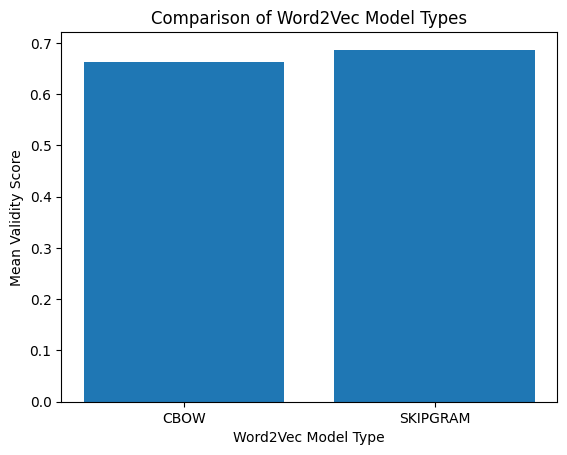

In [19]:
# Group the data by model type and calculate the mean validity score for each type
model_type_scores = word_2_vec_results_df.groupby('word2vec_mode_type')['validity_score'].mean()

# Plot the bar chart
plt.bar(model_type_scores.index, model_type_scores.values)
plt.xlabel('Word2Vec Model Type')
plt.ylabel('Mean Validity Score')
plt.title('Comparison of Word2Vec Model Types')
plt.show()

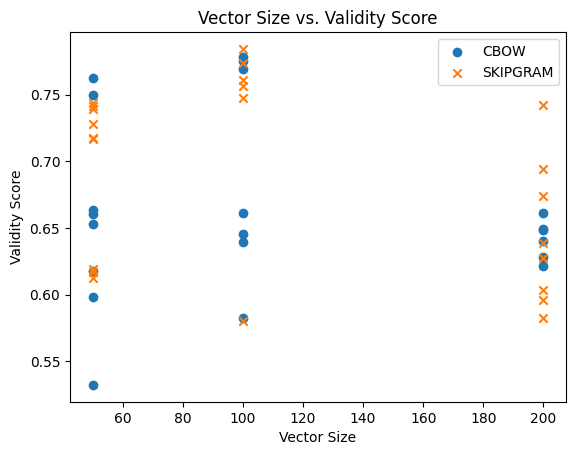

In [20]:
# Separate the data for CBOW and SKIPGRAM models
cbow_data = word_2_vec_results_df[word_2_vec_results_df['word2vec_mode_type'] == 'CBOW']
skipgram_data = word_2_vec_results_df[word_2_vec_results_df['word2vec_mode_type'] == 'SKIPGRAM']

# Plot the scatter plot for CBOW model
plt.scatter(cbow_data['vector_size'], cbow_data['validity_score'], label='CBOW', marker='o')

# Plot the scatter plot for SKIPGRAM model
plt.scatter(skipgram_data['vector_size'], skipgram_data['validity_score'], label='SKIPGRAM', marker='x')

plt.xlabel('Vector Size')
plt.ylabel('Validity Score')
plt.title('Vector Size vs. Validity Score')
plt.legend()
plt.show()

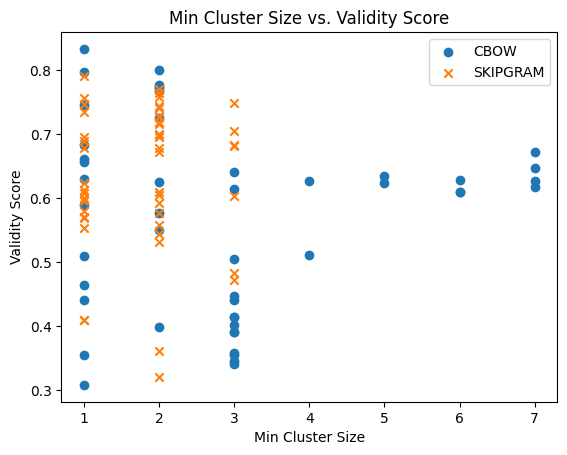

In [52]:
# Plot the scatter plot for CBOW model
plt.scatter(cbow_data['min_cluster_size'], cbow_data['validity_score'], label='CBOW', marker='o')

# Plot the scatter plot for SKIPGRAM model
plt.scatter(skipgram_data['min_cluster_size'], skipgram_data['validity_score'], label='SKIPGRAM', marker='x')

plt.xlabel('Min Cluster Size')
plt.ylabel('Validity Score')
plt.title('Min Cluster Size vs. Validity Score')
plt.legend()
plt.show()

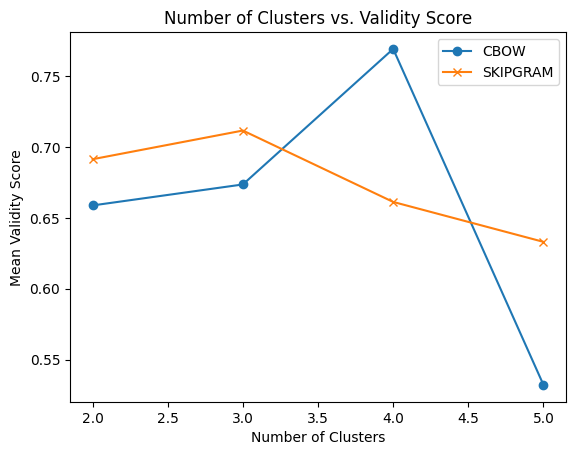

In [21]:
# Group the data by the number of clusters and calculate the mean validity score for each type
cluster_scores = word_2_vec_results_df.groupby(['word2vec_mode_type', 'n_clusters'])['validity_score'].mean()

# Plot the line chart for CBOW model
cbow_clusters = cluster_scores['CBOW'].index
cbow_validity_scores = cluster_scores['CBOW'].values
plt.plot(cbow_clusters, cbow_validity_scores, label='CBOW', marker='o')

# Plot the line chart for SKIPGRAM model
skipgram_clusters = cluster_scores['SKIPGRAM'].index
skipgram_validity_scores = cluster_scores['SKIPGRAM'].values
plt.plot(skipgram_clusters, skipgram_validity_scores, label='SKIPGRAM', marker='x')

plt.xlabel('Number of Clusters')
plt.ylabel('Mean Validity Score')
plt.title('Number of Clusters vs. Validity Score')
plt.legend()
plt.show()

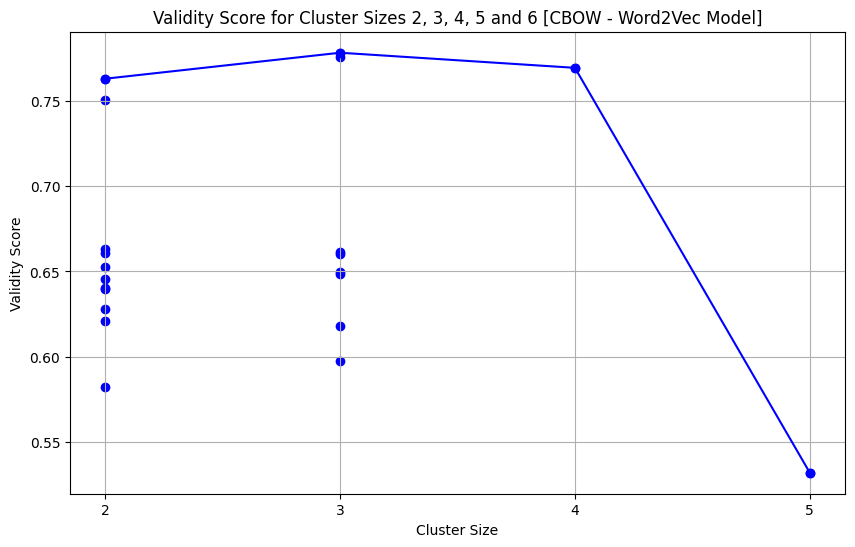

In [24]:
# Filter the data to include only rows where the number of clusters is 3, 4, or 5
data_cluster = cbow_data[cbow_data['n_clusters'].isin([2, 3, 4, 5])]

# Sort the data by the number of clusters for better visualization
data_cluster = data_cluster.sort_values(by='n_clusters')

# Extract the values for x-axis (cluster size) and y-axis (validity score)
x_values = data_cluster['n_clusters']
y_values = data_cluster['validity_score']

# Group the data by 'n_clusters' and find the maximum validity score for each cluster size
max_validity_scores = data_cluster.groupby('n_clusters')['validity_score'].max().reset_index()

# Extract the values for x-axis (cluster size) and y-axis (maximum validity score)
x_values_line = max_validity_scores['n_clusters']
y_values_line = max_validity_scores['validity_score']

# Create the line graph
plt.figure(figsize=(10, 6))
plt.scatter(x_values, y_values, marker='o', linestyle='-', color='b')
plt.plot(x_values_line, y_values_line, marker='o', linestyle='-', color='b')
plt.xlabel('Cluster Size')
plt.ylabel('Validity Score')
plt.title('Validity Score for Cluster Sizes 2, 3, 4, 5 and 6 [CBOW - Word2Vec Model]')
plt.xticks([2, 3, 4, 5])  # Ensure x-axis ticks are only 3, 4, and 5
plt.grid(True)
plt.show()

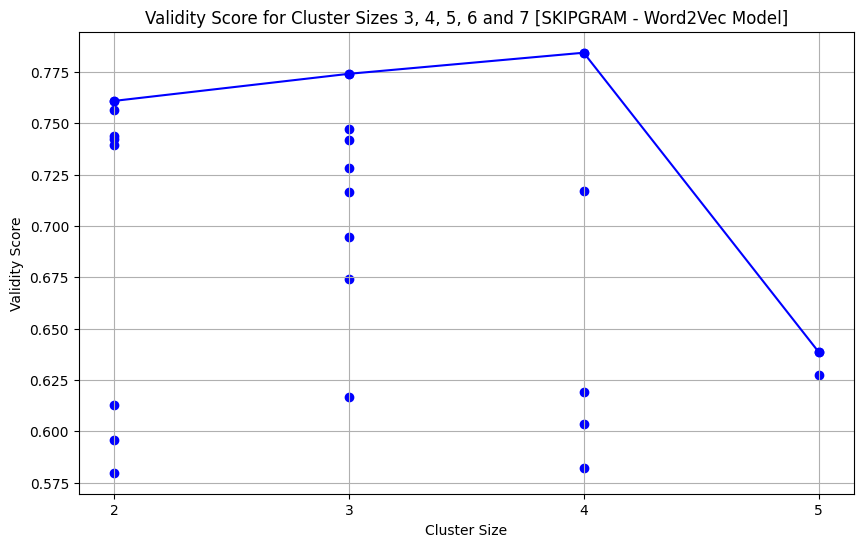

In [29]:
# Filter the data to include only rows where the number of clusters is 3, 4, or 5
data_cluster = skipgram_data[skipgram_data['n_clusters'].isin([2, 3, 4, 5])]

# Sort the data by the number of clusters for better visualization
data_cluster = data_cluster.sort_values(by='n_clusters')

# Extract the values for x-axis (cluster size) and y-axis (validity score)
x_values = data_cluster['n_clusters']
y_values = data_cluster['validity_score']

# Group the data by 'n_clusters' and find the maximum validity score for each cluster size
max_validity_scores = data_cluster.groupby('n_clusters')['validity_score'].max().reset_index()

# Extract the values for x-axis (cluster size) and y-axis (maximum validity score)
x_values_line = max_validity_scores['n_clusters']
y_values_line = max_validity_scores['validity_score']

# Create the line graph
plt.figure(figsize=(10, 6))
plt.scatter(x_values, y_values, marker='o', linestyle='-', color='b')
plt.plot(x_values_line, y_values_line, marker='o', linestyle='-', color='b')
plt.xlabel('Cluster Size')
plt.ylabel('Validity Score')
plt.title('Validity Score for Cluster Sizes 3, 4, 5, 6 and 7 [SKIPGRAM - Word2Vec Model]')
plt.xticks([2, 3, 4, 5])  # Ensure x-axis ticks are only 3, 4, and 5
plt.grid(True)
plt.show()

In [30]:
# Filter data to exclude clusters with less than 3 clusters for SKIPGRAM
skipgram_data_filtered = skipgram_data[skipgram_data['n_clusters'] >= 3]

# Find the best hyperparameter combination for SKIPGRAM with clusters >= 3
best_skipgram_params = skipgram_data_filtered.loc[skipgram_data_filtered['validity_score'].idxmax()]

# Check if there is at least one valid result with clusters >= 3 for SKIPGRAM
if not best_skipgram_params.empty:
    print("Best SKIPGRAM Hyperparameters:")
    print("Vector Size:", best_skipgram_params['vector_size'])
    print("Window:", best_skipgram_params['window'])
    print("Min Count:", best_skipgram_params['min_count'])
    print("Min Cluster Size:", best_skipgram_params['min_cluster_size'])
    print("Min Samples:", best_skipgram_params['min_samples'])
    print("Cluster Selection Epsilon:", best_skipgram_params['cluster_selection_epsilon'])
    print("Validity Score:", best_skipgram_params['validity_score'])
    print("Number of Clusters:", best_skipgram_params['n_clusters'])
else:
    print("No valid SKIPGRAM results with clusters >= 3 found.")

Best SKIPGRAM Hyperparameters:
Vector Size: 100
Window: 5
Min Count: 10
Min Cluster Size: 2
Min Samples: 8
Cluster Selection Epsilon: 0.2
Validity Score: 0.7843004641907126
Number of Clusters: 4


In [31]:
# Filter data to exclude clusters with less than 3 clusters for CBOW
cbow_data_filtered = cbow_data[cbow_data['n_clusters'] >= 3]

# Find the best hyperparameter combination for CBOW with clusters >= 3
best_cbow_params = cbow_data_filtered.loc[cbow_data_filtered['validity_score'].idxmax()]

# Check if there is at least one valid result with clusters >= 3 for CBOW
if not best_cbow_params.empty:
    print("Best CBOW Hyperparameters:")
    print("Vector Size:", best_cbow_params['vector_size'])
    print("Window:", best_cbow_params['window'])
    print("Min Count:", best_cbow_params['min_count'])
    print("Min Cluster Size:", best_cbow_params['min_cluster_size'])
    print("Min Samples:", best_cbow_params['min_samples'])
    print("Cluster Selection Epsilon:", best_cbow_params['cluster_selection_epsilon'])
    print("Validity Score:", best_cbow_params['validity_score'])
    print("Number of Clusters:", best_cbow_params['n_clusters'])
else:
    print("No valid CBOW results with clusters >= 3 found.")

Best CBOW Hyperparameters:
Vector Size: 100
Window: 2
Min Count: 10
Min Cluster Size: 3
Min Samples: 1
Cluster Selection Epsilon: 0.2
Validity Score: 0.7780001027546334
Number of Clusters: 3


## Document Clustering using Sentence BERT

In [32]:
from sentence_transformers import SentenceTransformer

In [33]:
#all_mpnet_base_v2_sentence_transformer_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

In [34]:
#sentence_transformers_embeddings = all_mpnet_base_v2_sentence_transformer_model.encode(job_descriptions_df['description'])

In [35]:
SENTENCE_BERT_EMBEDDINGS_PATH = os.getcwd() + '/resources/embeddings/sentence_bert_embeddings/sentence_bert_embeddings.npy'

if os.path.exists(SENTENCE_BERT_EMBEDDINGS_PATH):
    # Load the saved embeddings from the file
    sentence_transformers_embeddings = np.load(SENTENCE_BERT_EMBEDDINGS_PATH)
else:
    # Load the SentenceTransformer model and perform embeddings
    all_mpnet_base_v2_sentence_transformer_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
    sentence_transformers_embeddings = all_mpnet_base_v2_sentence_transformer_model.encode(job_descriptions_df['description'])
    
    # Save the embeddings to an npy file
    np.save(SENTENCE_BERT_EMBEDDINGS_PATH, sentence_transformers_embeddings)

print(f"Embedding Size from Sentence Bert: {sentence_transformers_embeddings.shape}")

Embedding Size from Sentence Bert: (3530, 768)


In [23]:
# SENTENCE_BERT_EMBEDDINGS_PATH = os.getcwd() + '/resources/embeddings/sentence_bert_embeddings/' + 'sentence_bert_embeddings.npy'
# print(f"Sentence BERT Embeddings Save Path: {SENTENCE_BERT_EMBEDDINGS_PATH}")
# np.save(SENTENCE_BERT_EMBEDDINGS_PATH, sentence_transformers_embeddings)

In [36]:
# Dimensionality Reduction to 2 dimensions
dim_red = DimensionalityReduction()
document_embeddings_2d = dim_red.apply_umap(sentence_transformers_embeddings)

# Define a parameter grid for hyperparameter search
param_grid = {
                'min_cluster_size': range(1, int(2 * np.log(document_embeddings_2d.shape[0]))), # -> Important
                'min_samples': range(1, int(2 * np.log(document_embeddings_2d.shape[0]))), # -> Important
                #'allow_single_cluster': [True, False], # -> Tune this later
                'cluster_selection_epsilon': [0.0, 0.1, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0, 1.2, 1.5, 2.0] # -> Important
                }

# Finding optimal Clusters and Optimizing HDBSCAN Clustering
hdbscan_tuner = HDBSCANTuner(embedding_model_type='sentence_bert', cluster_selection_method='leaf')
hdbscan_tuner.hyperparameter_search(document_embeddings_2d, param_grid)

# Get the best hyperparameters and the best HDBSCAN model
best_hyperparameters, best_hdbscan_model = hdbscan_tuner.get_best_hyperparameters_and_best_model()
print('Best hyperparameters:', best_hyperparameters)

Performing the Dimensionality reduction.
Performing Hyperparameter Tuning of HDDBSCAN using Grid Search.
Hyperparameters: {'cluster_selection_epsilon': 0.0, 'min_cluster_size': 4, 'min_samples': 7}
Validity Score: 0.5736602362291281
n_clusters: 2

Hyperparameters: {'cluster_selection_epsilon': 0.0, 'min_cluster_size': 4, 'min_samples': 8}
Validity Score: 0.5736602362291281
n_clusters: 2

Hyperparameters: {'cluster_selection_epsilon': 0.0, 'min_cluster_size': 4, 'min_samples': 9}
Validity Score: 0.5736602362291281
n_clusters: 2

Hyperparameters: {'cluster_selection_epsilon': 0.0, 'min_cluster_size': 5, 'min_samples': 2}
Validity Score: 0.5453593636302112
n_clusters: 2

Hyperparameters: {'cluster_selection_epsilon': 0.0, 'min_cluster_size': 5, 'min_samples': 3}
Validity Score: 0.5453593636302112
n_clusters: 2

Hyperparameters: {'cluster_selection_epsilon': 0.0, 'min_cluster_size': 5, 'min_samples': 4}
Validity Score: 0.6398324460057813
n_clusters: 2

Hyperparameters: {'cluster_selection_

In [38]:
# Create a dictionary containing the model data
model_data = {
                'full_size_embedding': sentence_transformers_embeddings,
                'dim_reduction_class': dim_red,
                'two_d_embeddings': document_embeddings_2d,
                'final_hdbscan_model': best_hdbscan_model
            }
            
# Define the file name for the pickle file
file_name = f'sentence_bert_HDBSCAN_model_information.pkl'

# Save the model_data dictionary to a pickle file
with open(os.getcwd() + '/resources/models/sentence_bert_model/' + file_name, 'wb') as f:
    pickle.dump(model_data, f)

In [39]:
print("Optimized HDBSCAN Hyperparameters with Sentence BERT: ")
{'min_cluster_size':best_hyperparameters['params']['min_cluster_size'],
'cluster_selection_epsilon':best_hyperparameters['params']['cluster_selection_epsilon'],
'min_samples':best_hyperparameters['params']['min_samples'],
'validity_score':best_hyperparameters['validity_score'],
'n_clusters':best_hyperparameters['n_clusters']}

Optimized HDBSCAN Hyperparameters with Sentence BERT: 


{'min_cluster_size': 1,
 'cluster_selection_epsilon': 1.5,
 'min_samples': 4,
 'validity_score': 0.7093020236273041,
 'n_clusters': 3}

## Document Clustering using Doc2Vec

In [44]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import numpy as np

class Doc2VecVectorizer:
    def __init__(self, vector_size=100, window=5, min_count=1, epochs=100):
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.epochs = epochs
        self.model = None

    def tokenize_text(self, text):
        # Tokenize the input text (customize as needed)
        return word_tokenize(text.lower())  # You can customize the tokenization as per your data

    def preprocess_documents(self, documents):
        """
        Preprocess a list of documents and convert them to TaggedDocument format.
        Args:
            documents (list): List of text documents.
        Returns:
            tagged_data (list of TaggedDocument): List of tagged documents.
        """
        print('Processing and Preparing Job Description for Doc2Vec')
        tagged_data = []
        for i, doc in enumerate(documents):
            words = self.tokenize_text(doc)
            tagged_data.append(TaggedDocument(words=words, tags=[str(i)]))
        return tagged_data

    def train_model(self, tagged_data):
        """
        Train the Doc2Vec model on tagged data.
        Args:
            tagged_data (list of TaggedDocument): List of tagged documents.
        Returns:
            model (Doc2Vec): Trained Doc2Vec model.
        """
        print('Training Doc2Vec on Raw Job Description')
        self.model = Doc2Vec(vector_size=self.vector_size, window=self.window,
                             min_count=self.min_count, epochs=self.epochs, workers=4)
        self.model.build_vocab(tagged_data)
        self.model.train(tagged_data, total_examples=self.model.corpus_count, epochs=self.model.epochs)
        return self.model

    def vectorize_document(self, document):
        """
        Vectorize a single document using the trained Doc2Vec model.
        Args:
            document (str): Text document to vectorize.
        Returns:
            vector (np.array): Document vector.
        """
        words = self.tokenize_text(document)
        vector = self.model.infer_vector(words)
        return vector

    def vectorize_documents(self, documents):
        """
        Vectorize a list of documents using the trained Doc2Vec model.
        Args:
            documents (list): List of text documents to vectorize.
        Returns:
            vectors (np.array): Array of document vectors.
        """
        print("Vectorizing documents using Doc2Vec")
        vectors = [self.vectorize_document(doc) for doc in documents]#tqdm(documents, desc="Vectorizing Documents using Doc2Vec: ")]
        return np.array(vectors)
    
    def save_embeddings_to_npy(self, filename, vectorized_docs):
        """
        Save the Doc2Vec embeddings to an npy file.
        Args:
            filename (str): File path to save the embeddings.
            vectorized_docs (np.array): Array of document vectors.
        """
        if self.model is None:
            raise ValueError("Model is not trained. Call 'train_model' before saving embeddings.")
        print('Saving the Doc2Vec Embeddings')
        np.save(filename, vectorized_docs)

In [55]:
vector_sizes = [50,100,200]
windows = [2,5,10]
min_counts = [2,5,10]

doc2vec_model_index = 0

# results_df = pd.DataFrame(columns=['vector_size', 'window', 'min_count', 'min_cluster_size', 'min_samples',
#                                    'cluster_selection_epsilon', 'validity_score', 'n_clusters'])
results_list = []

# Iterate over different combinations of hyperparameters
for vector_size in vector_sizes:
    for window in windows:
        for min_count in min_counts:
            print("#"*100)
            print("=> Trying Doc2Vec parameters: {}".format(str({'vector size': vector_size,
                                            'window': window,
                                            'min_count': min_count})))

            # Embedding Job Description using Doc2Vec
            doc2vec_vectorizer = Doc2VecVectorizer(vector_size=vector_size,
                                                    window=window,
                                                    min_count=min_count, epochs=100)
            tagged_data = doc2vec_vectorizer.preprocess_documents(job_descriptions_df['description'])
            trained_doc2vec_model = doc2vec_vectorizer.train_model(tagged_data)
            vectorized_docs = doc2vec_vectorizer.vectorize_documents(job_descriptions_df['description'])

            doc2vec_vectorizer.save_embeddings_to_npy(os.getcwd() + '/resources/embeddings/doc2vec_embeddings/' + f'doc2vec_embeddings_{doc2vec_model_index}.npy',
                                                      vectorized_docs=vectorized_docs)

            # Performing Dimensionality Reduction
            dim_red = DimensionalityReduction()
            document_embeddings_2d = dim_red.apply_umap(vectorized_docs)

            # Optimizing the HDBSCAN Clustering and finding optimal cluster
            print("=> Optimizing HDBSCAN and Finding Optimal Number of Clusters")
            param_grid = {
                'min_cluster_size': range(1, int(2 * np.log(document_embeddings_2d.shape[0]))), # -> Important
                'min_samples': range(1, int(2 * np.log(document_embeddings_2d.shape[0]))), # -> Important
                #'allow_single_cluster': [True, False], # -> Tune this later
                'cluster_selection_epsilon': [0.0, 0.1, 0.2, 0.4, 0.5, 0.8, 1.0] # -> Important
                }

            hdbscan_tuner = HDBSCANTuner(embedding_model_type='doc2vec',cluster_selection_method='leaf')
            hdbscan_tuner.hyperparameter_search(document_embeddings_2d, param_grid)
            best_hyperparameters, best_hdbscan_model = hdbscan_tuner.get_best_hyperparameters_and_best_model()

            

            if best_hyperparameters is not None:
                print('Best hyperparameters:', best_hyperparameters)

                # save the combination of word2vec, tf-idf vectorizer,dim_reduction_class, its embeddings, 2-D embeddings and best optimized HDBSCAN model
                model_data = {
                    'trained_doc2vec_model': trained_doc2vec_model,
                    'full_size_embedding': vectorized_docs,
                    'dim_reduction_class': dim_red,
                    'two_d_embeddings': document_embeddings_2d,
                    'final_hdbscan_model': best_hdbscan_model
                }

                # Save the model_data dictionary to a pickle file
                file_name = f'model_id_{doc2vec_model_index}.pkl'
                with open(os.getcwd() + '/resources/models/doc_2_vec_models/' + file_name, 'wb') as f:
                    pickle.dump(model_data, f)

                # Storing the results for each combination of hyperparameters
                results_list.append({
                    'model_id': doc2vec_model_index,
                    'vector_size': vector_size,
                    'window': window,
                    'min_count': min_count,
                    'min_cluster_size': best_hyperparameters['params']['min_cluster_size'],
                    'min_samples': best_hyperparameters['params']['min_samples'],
                    'cluster_selection_epsilon': best_hyperparameters['params']['cluster_selection_epsilon'],
                    'validity_score': best_hyperparameters['validity_score'],
                    'n_clusters': best_hyperparameters['n_clusters']
                })
                        

            print("#"*100)
            print("\n\n")
            doc2vec_model_index = doc2vec_model_index + 1

# Creating the DataFrame from the list of dictionaries
doc_2_vec_results_df = pd.DataFrame(results_list)

####################################################################################################
=> Trying Doc2Vec parameters: {'vector size': 50, 'window': 2, 'min_count': 2}
Processing and Preparing Job Description for Doc2Vec
Training Doc2Vec on Raw Job Description
Vectorizing documents using Doc2Vec
Saving the Doc2Vec Embeddings
Performing the Dimensionality reduction.
=> Optimizing HDBSCAN and Finding Optimal Number of Clusters
Performing Hyperparameter Tuning of HDDBSCAN using Grid Search.
Hyperparameters: {'cluster_selection_epsilon': 0.2, 'min_cluster_size': 1, 'min_samples': 1}
Validity Score: 0.6649295240556632
n_clusters: 3

Hyperparameters: {'cluster_selection_epsilon': 0.2, 'min_cluster_size': 1, 'min_samples': 2}
Validity Score: 0.6635340093393017
n_clusters: 3

Hyperparameters: {'cluster_selection_epsilon': 0.2, 'min_cluster_size': 1, 'min_samples': 3}
Validity Score: 0.6548600616678797
n_clusters: 3

Hyperparameters: {'cluster_selection_epsilon': 0.2, 'min_cluster_s

In [56]:
# Save the result of hyperparameter optimization in a csv file
doc_2_vec_results_df.to_csv('doc2vec_HDBSCAN_hyperparameter_results.csv',index=False)

### Doc2Vec Embeddings + HDBSCAN Evaluation and Comparison

In [57]:
# Load the result of Doc2Vec training 
doc_2_vec_results_df = pd.read_csv('doc2vec_HDBSCAN_hyperparameter_results.csv')

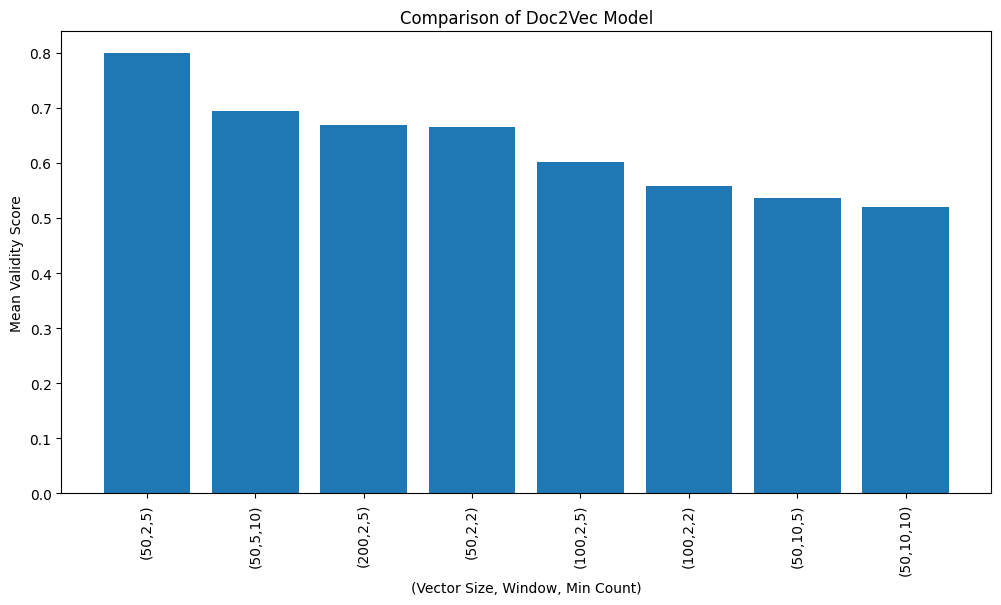

In [58]:
# Group the data by vector_size, window, and min_count and calculate the mean validity score for each combination
doc2vec_grouped = doc_2_vec_results_df.groupby(['vector_size', 'window', 'min_count'])['validity_score'].mean().reset_index()
# Sort the DataFrame by mean validity score in descending order
doc2vec_grouped_sorted = doc2vec_grouped.sort_values(by='validity_score', ascending=False)

# Plot the bar chart
plt.figure(figsize=(12, 6))
x_labels = ['({},{},{})'.format(vec, win, min_c) for vec, win, min_c in zip(doc2vec_grouped_sorted['vector_size'], doc2vec_grouped_sorted['window'], doc2vec_grouped_sorted['min_count'])]
plt.bar(x_labels, doc2vec_grouped_sorted['validity_score'])
plt.xlabel('(Vector Size, Window, Min Count)')
plt.ylabel('Mean Validity Score')
plt.title('Comparison of Doc2Vec Model')
plt.xticks(rotation=90)
plt.show()

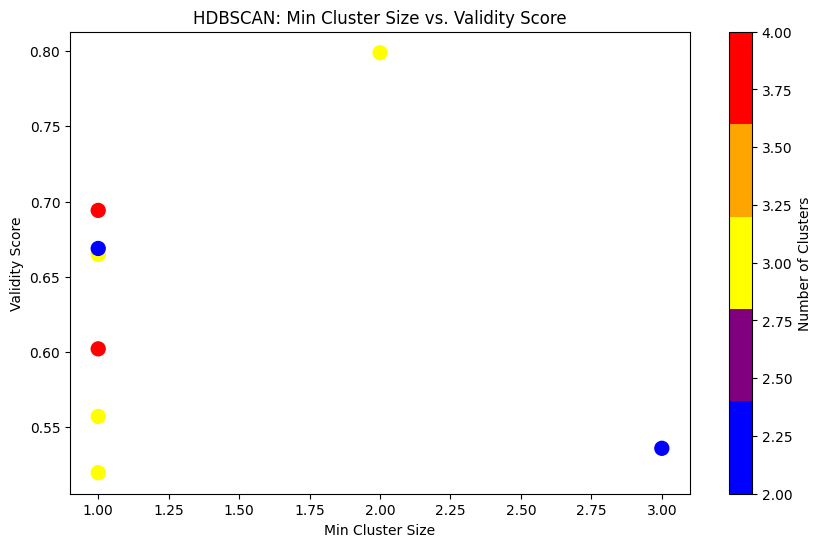

In [59]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define a custom colormap that limits the number of clusters between 2 and 6
cmap_custom = mcolors.LinearSegmentedColormap.from_list('custom_cmap', ['blue', 'purple', 'yellow', 'orange', 'red'], N=5)


filtered_results = doc_2_vec_results_df[doc_2_vec_results_df['n_clusters'] <= 5]

# Scatter plot for Min Cluster Size
plt.figure(figsize=(10, 6))
plt.scatter(filtered_results['min_cluster_size'], filtered_results['validity_score'], c=filtered_results['n_clusters'], cmap=cmap_custom, s=100)
plt.colorbar(label='Number of Clusters')
plt.xlabel('Min Cluster Size')
plt.ylabel('Validity Score')
plt.title('HDBSCAN: Min Cluster Size vs. Validity Score')
plt.show()

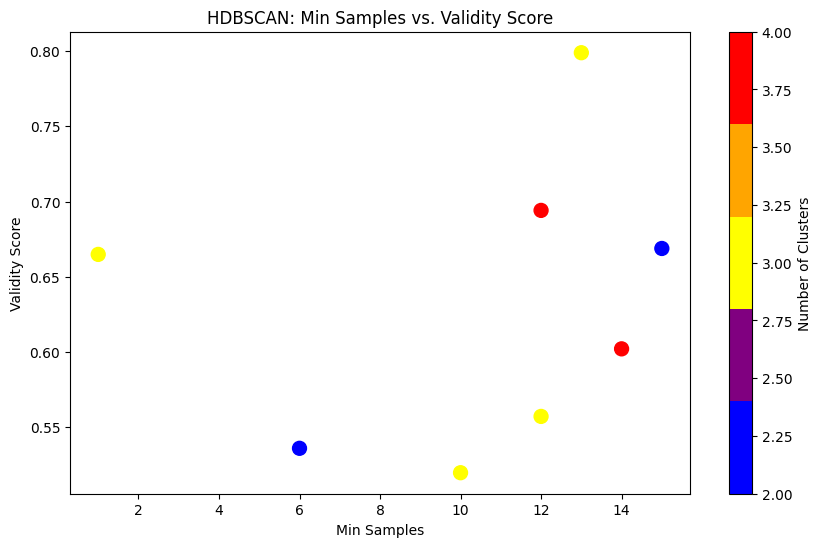

In [60]:
# Scatter plot for Min Samples
plt.figure(figsize=(10, 6))
plt.scatter(filtered_results['min_samples'], filtered_results['validity_score'], c=filtered_results['n_clusters'], cmap=cmap_custom, s=100)
plt.colorbar(label='Number of Clusters')
plt.xlabel('Min Samples')
plt.ylabel('Validity Score')
plt.title('HDBSCAN: Min Samples vs. Validity Score')
plt.show()

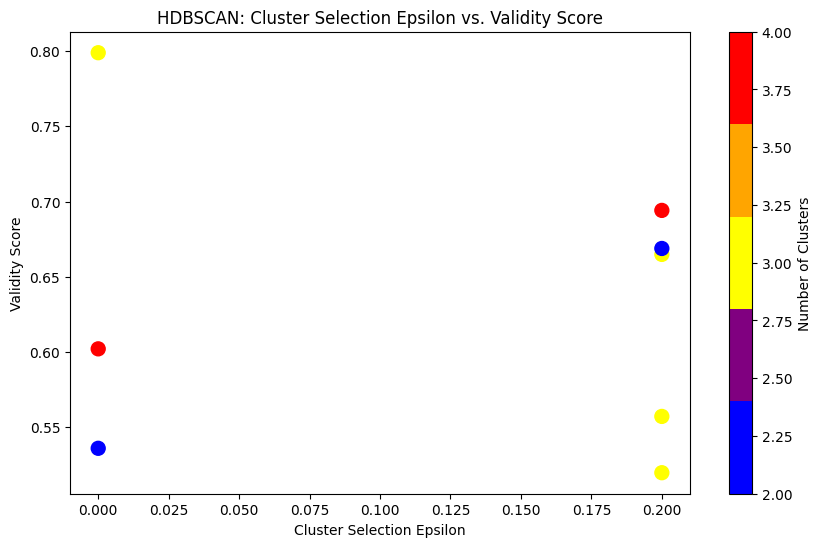

In [61]:
# Scatter plot for Cluster Selection Epsilon
plt.figure(figsize=(10, 6))
plt.scatter(filtered_results['cluster_selection_epsilon'], filtered_results['validity_score'], c=filtered_results['n_clusters'], cmap=cmap_custom, s=100)
plt.colorbar(label='Number of Clusters')
plt.xlabel('Cluster Selection Epsilon')
plt.ylabel('Validity Score')
plt.title('HDBSCAN: Cluster Selection Epsilon vs. Validity Score')
plt.show()

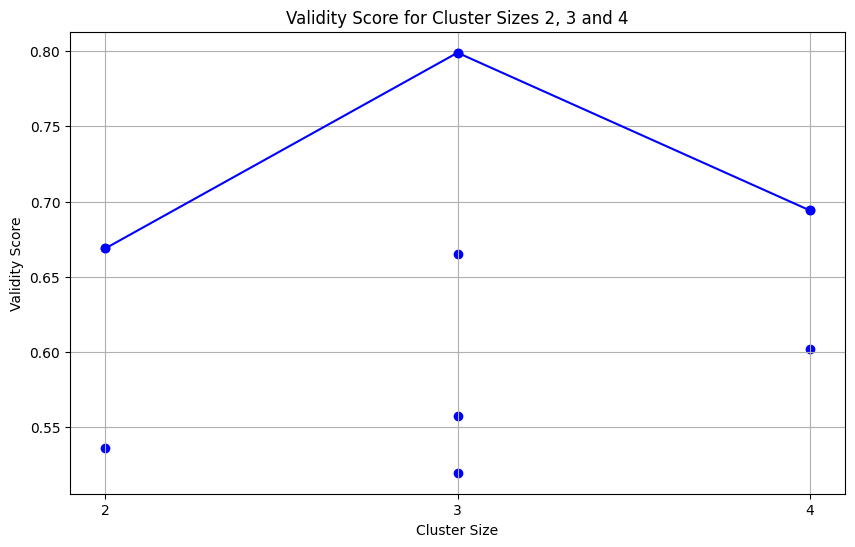

In [106]:
# Filter the data to include only rows where the number of clusters is 3, 4, or 5
data_cluster = doc_2_vec_results_df[doc_2_vec_results_df['n_clusters'].isin([2, 3, 4])]

# Sort the data by the number of clusters for better visualization
data_cluster = data_cluster.sort_values(by='n_clusters')

# Extract the values for x-axis (cluster size) and y-axis (validity score)
x_values = data_cluster['n_clusters']
y_values = data_cluster['validity_score']

# Group the data by 'n_clusters' and find the maximum validity score for each cluster size
max_validity_scores = data_cluster.groupby('n_clusters')['validity_score'].max().reset_index()

# Extract the values for x-axis (cluster size) and y-axis (maximum validity score)
x_values_line = max_validity_scores['n_clusters']
y_values_line = max_validity_scores['validity_score']

# Create the line graph
plt.figure(figsize=(10, 6))
plt.scatter(x_values, y_values, marker='o', linestyle='-', color='b')
plt.plot(x_values_line, y_values_line, marker='o', linestyle='-', color='b')
plt.xlabel('Cluster Size')
plt.ylabel('Validity Score')
plt.title('Validity Score for Cluster Sizes 2, 3 and 4')
plt.xticks([2, 3, 4])  # Ensure x-axis ticks are only 3, 4, and 5
plt.grid(True)
plt.show()

In [63]:
# Filter the data to include only rows where the number of clusters is either 3 or 4
filtered_data = doc_2_vec_results_df[doc_2_vec_results_df['n_clusters'].isin([3, 4])]

# Find the row with the highest validation score from the filtered data
best_hyperparameters = filtered_data.loc[filtered_data['validity_score'].idxmax()]

# Print the hyperparameters with the highest validation score when the number of clusters is either 3 or 4
print("Best Hyperparameters with Number of Clusters 3 or 4:")
print("Vector Size:", best_hyperparameters['vector_size'])
print("Window:", best_hyperparameters['window'])
print("Min Count:", best_hyperparameters['min_count'])
print("Min Cluster Size:", best_hyperparameters['min_cluster_size'])
print("Min Samples:", best_hyperparameters['min_samples'])
print("Cluster Selection Epsilon:", best_hyperparameters['cluster_selection_epsilon'])
print("Validity Score:", best_hyperparameters['validity_score'])
print("Number of Clusters:", best_hyperparameters['n_clusters'])


Best Hyperparameters with Number of Clusters 3 or 4:
Vector Size: 50.0
Window: 2.0
Min Count: 5.0
Min Cluster Size: 2.0
Min Samples: 13.0
Cluster Selection Epsilon: 0.0
Validity Score: 0.7989217023122028
Number of Clusters: 3.0


In [64]:
# Filter the data to include only rows where the number of clusters is either 3 or 4
filtered_data = doc_2_vec_results_df[doc_2_vec_results_df['n_clusters'].isin([3, 4])]

# Find the row with the highest validation score for 3 clusters
best_hyperparameters_3_clusters = filtered_data[filtered_data['n_clusters'] == 3].nlargest(1, 'validity_score')

# Find the row with the highest validation score for 4 clusters
best_hyperparameters_4_clusters = filtered_data[filtered_data['n_clusters'] == 4].nlargest(1, 'validity_score')

# Concatenate the two dataframes to get the best hyperparameters for both 3 and 4 clusters
best_hyperparameters = pd.concat([best_hyperparameters_3_clusters, best_hyperparameters_4_clusters])

# Print the best hyperparameters for both 3 and 4 clusters
print("Best Hyperparameters for 3 Clusters:")
print(best_hyperparameters[best_hyperparameters['n_clusters'] == 3][['vector_size', 'window', 'min_count', 'min_cluster_size', 'min_samples', 'cluster_selection_epsilon', 'validity_score']])
print("\nBest Hyperparameters for 4 Clusters:")
print(best_hyperparameters[best_hyperparameters['n_clusters'] == 4][['vector_size', 'window', 'min_count', 'min_cluster_size', 'min_samples', 'cluster_selection_epsilon', 'validity_score']])


Best Hyperparameters for 3 Clusters:
   vector_size  window  min_count  min_cluster_size  min_samples  \
1           50       2          5                 2           13   

   cluster_selection_epsilon  validity_score  
1                        0.0        0.798922  

Best Hyperparameters for 4 Clusters:
   vector_size  window  min_count  min_cluster_size  min_samples  \
2           50       5         10                 1           12   

   cluster_selection_epsilon  validity_score  
2                        0.2        0.694163  


## Final Selection of the best Clustering model

In [67]:
from sklearn import metrics

### Silhouette and Davies-Bouldin Index Score of best CBOW Word2Vec model

In [94]:
file_name = '/home/ubuntu/Thesis/Experiments/STAGE I - Document Clustering/resources/models/word_2_vec_models/model_id_22.pkl'

# Load the model data from the pickle file
with open(file_name, 'rb') as f:
    best_cbow_word2vec_model_data = pickle.load(f)

In [95]:
# Get the labels from HDBSCAN model
hdbscan_labels = best_cbow_word2vec_model_data['final_hdbscan_model'].labels_

# Find the indices where the label is not equal to -1 (not noise)
valid_indices = np.where(hdbscan_labels != -1)[0]

# Use boolean indexing to filter the valid data points from 'two_d_embeddings'
valid_embeddings = best_cbow_word2vec_model_data['two_d_embeddings'][valid_indices]

# Calculate the Silhouette Score for the valid embeddings
silhouette_score_cbow_valid = metrics.silhouette_score(valid_embeddings, hdbscan_labels[valid_indices])

# Calculate the DBI Score for the valid embeddings
dbi_score_cbow_valid = metrics.davies_bouldin_score(valid_embeddings, hdbscan_labels[valid_indices])

In [96]:
# Print the Silhouette Score for the valid embeddings
print(f"Silhouette Score for valid data points with best CBOW Word2Vec Embeddings: {silhouette_score_cbow_valid:.3f}")

# Print the Davies-Bouldin Index Score for the valid embeddings
print(f"Davies-Bouldin Index Score for valid data points with best CBOW Word2Vec Embeddings: {dbi_score_cbow_valid:.3f}")

Silhouette Score for valid data points with best CBOW Word2Vec Embeddings: 0.432
Davies-Bouldin Index Score for valid data points with best CBOW Word2Vec Embeddings: 0.612


### Silhouette and Davies-Bouldin Index  Score of best SKIPGRAM Word2Vec model

In [97]:
file_name = '/home/ubuntu/Thesis/Experiments/STAGE I - Document Clustering/resources/models/word_2_vec_models/model_id_29.pkl'

# Load the model data from the pickle file
with open(file_name, 'rb') as f:
    best_skipgram_word2vec_model_data = pickle.load(f)

In [98]:
# Get the labels from HDBSCAN model
hdbscan_labels = best_skipgram_word2vec_model_data['final_hdbscan_model'].labels_

# Find the indices where the label is not equal to -1 (not noise)
valid_indices = np.where(hdbscan_labels != -1)[0]

# Use boolean indexing to filter the valid data points from 'two_d_embeddings'
valid_embeddings = best_skipgram_word2vec_model_data['two_d_embeddings'][valid_indices]

# Calculate the Silhouette Score for the valid embeddings
silhouette_score_skipgram_valid = metrics.silhouette_score(valid_embeddings, hdbscan_labels[valid_indices])


# Calculate the DBI Score for the valid embeddings
dbi_score_skipgram_valid = metrics.davies_bouldin_score(valid_embeddings, hdbscan_labels[valid_indices])

In [99]:
# Print the Silhouette Score for the valid embeddings
print(f"Silhouette Score for valid data points with best SKIPGRAM Word2Vec Embeddings: {silhouette_score_skipgram_valid:.3f}")

# Print the Davies-Bouldin Index Score for the valid embeddings
print(f"Davies-Bouldin Index Score for valid data points with best SKIPGRAM Word2Vec Embeddings: {dbi_score_skipgram_valid:.3f}")

Silhouette Score for valid data points with best SKIPGRAM Word2Vec Embeddings: 0.483
Davies-Bouldin Index Score for valid data points with best SKIPGRAM Word2Vec Embeddings: 0.721


### Silhouette and Davies-Bouldin Index Score with Sentence BERT model

In [100]:
file_name = '/home/ubuntu/Thesis/Experiments/STAGE I - Document Clustering/resources/models/sentence_bert_model/sentence_bert_HDBSCAN_model_information.pkl'

# Load the model data from the pickle file
with open(file_name, 'rb') as f:
    sentence_bert_model_data = pickle.load(f)

In [101]:
# Get the labels from HDBSCAN model
hdbscan_labels = sentence_bert_model_data['final_hdbscan_model'].labels_

# Find the indices where the label is not equal to -1 (not noise)
valid_indices = np.where(hdbscan_labels != -1)[0]

# Use boolean indexing to filter the valid data points from 'two_d_embeddings'
valid_embeddings = sentence_bert_model_data['two_d_embeddings'][valid_indices]

# Calculate the Silhouette Score for the valid embeddings
silhouette_score_sentence_bert_valid = metrics.silhouette_score(valid_embeddings, hdbscan_labels[valid_indices])


# Calculate the DBI Score for the valid embeddings
dbi_score_sentence_bert_valid = metrics.davies_bouldin_score(valid_embeddings, hdbscan_labels[valid_indices])

In [102]:
# Print the Silhouette Score for the valid embeddings
print(f"Silhouette Score for valid data points with Sentence BERT Embeddings: {silhouette_score_skipgram_valid:.3f}")

# Print the Davies-Bouldin Index Score for the valid embeddings
print(f"Davies-Bouldin Index Score for valid data points with Sentence BERT Embeddings: {dbi_score_sentence_bert_valid:.3f}")

Silhouette Score for valid data points with Sentence BERT Embeddings: 0.483
Davies-Bouldin Index Score for valid data points with Sentence BERT Embeddings: 0.389


In [121]:
print(f"Number of Clusters from Sentence Embeddings: {len(np.where(np.unique(hdbscan_labels) != -1)[0])}")

Number of Clusters from Sentence Embeddings: 4


### Silhouette and Davies-Bouldin Index  Score with Doc2Vec model

In [103]:
file_name = '/home/ubuntu/Thesis/Experiments/STAGE I - Document Clustering/resources/models/word_2_vec_models/model_id_1.pkl'

# Load the model data from the pickle file
with open(file_name, 'rb') as f:
    doc2vec_model_data = pickle.load(f)

In [104]:
# Get the labels from HDBSCAN model
hdbscan_labels = doc2vec_model_data['final_hdbscan_model'].labels_

# Find the indices where the label is not equal to -1 (not noise)
valid_indices = np.where(hdbscan_labels != -1)[0]

# Use boolean indexing to filter the valid data points from 'two_d_embeddings'
valid_embeddings = doc2vec_model_data['two_d_embeddings'][valid_indices]

# Calculate the Silhouette Score for the valid embeddings
silhouette_score_doc2vec_valid = metrics.silhouette_score(valid_embeddings, hdbscan_labels[valid_indices])

# Calculate the DBI Score for the valid embeddings
dbi_score_doc2vec_valid  = metrics.davies_bouldin_score(valid_embeddings, hdbscan_labels[valid_indices])

# Print the Silhouette Score for the valid embeddings
print(f"Silhouette Score for valid data points with Doc2Vec Embeddings: {silhouette_score_skipgram_valid:.3f}")

# Print the Davies-Bouldin Index Score for the valid embeddings
print(f"Davies-Bouldin Index Score for valid data points with Doc2Vec Embeddings: {dbi_score_doc2vec_valid:.3f}")

Silhouette Score for valid data points with Doc2Vec Embeddings: 0.483
Davies-Bouldin Index Score for valid data points with Doc2Vec Embeddings: 0.776


## Training Final Sentence BERT Clustering Model with optimal Clusters 

In [136]:
from sklearn.cluster import KMeans
import plotly.express as px
import plotly.graph_objects as go

In [143]:
file_name = '/home/ubuntu/Thesis/Experiments/STAGE I - Document Clustering/resources/models/sentence_bert_model/sentence_bert_HDBSCAN_model_information.pkl'

# Load the model data from the pickle file
with open(file_name, 'rb') as f:
    sentence_bert_model_data = pickle.load(f)

In [144]:
sentence_bert_model_data.keys()

dict_keys(['full_size_embedding', 'dim_reduction_class', 'two_d_embeddings', 'final_hdbscan_model'])

In [145]:
full_size_sentence_bert_embeddings = sentence_bert_model_data['full_size_embedding']
full_size_sentence_bert_embeddings.shape

(3530, 768)

In [146]:
two_dimension_embeddings = sentence_bert_model_data['dim_reduction_class'].apply_umap(full_size_sentence_bert_embeddings)
two_dimension_embeddings.shape

Performing the Dimensionality reduction.


(3530, 2)

In [147]:
sentence_bert_model_data['final_hdbscan_model'].labels_

array([1, 1, 1, ..., 2, 2, 2])

In [141]:
# Get the labels from HDBSCAN model
hdbscan_labels = sentence_bert_model_data['final_hdbscan_model'].labels_
print(f"Labels obtained from optimzied HDBSCAN Clusters: {np.unique(hdbscan_labels)}")

Labels obtained from optimzied HDBSCAN Clusters: [0 1 2 3]


In [123]:
# Find the indices where the label is not equal to -1 (not noise)
valid_indices = np.where(hdbscan_labels != -1)[0]

# Use boolean indexing to filter the valid data points from 'two_d_embeddings'
valid_embeddings = two_dimension_embeddings[valid_indices]

In [125]:
# Create a KMeans object with 4 clusters and k-means++ initialization
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42, n_init = 1000, max_iter = 1000, algorithm = 'elkan')

# Fit the KMeans model to your data
kmeans.fit(valid_embeddings)

# Get the cluster centers and labels
cluster_centers = kmeans.cluster_centers_
labels = kmeans.labels_

print(f"Silhouette Coefficient with Sentence BERT Embeddings trained with K-Means Clustering: {metrics.silhouette_score(valid_embeddings, labels):.3f}")

Silhouette Coefficient with Sentence BERT Embeddings trained with K-Means Clustering: 0.581


In [132]:
# Create a scatter plot for each cluster
colors = px.colors.qualitative.Set3  # Use distinct colors for valid clusters
fig = go.Figure()

for cluster_num in range(4):
    # Filter data points belonging to the current cluster
    cluster_points = valid_embeddings[labels == cluster_num]
    
    # Set opacity for valid clusters (less visible)
    opacity = 0.4
    
    # Plot the data points in the current cluster with a specific color and opacity
    fig.add_trace(go.Scatter(x=cluster_points[:, 0], y=cluster_points[:, 1], mode='markers',
                             marker=dict(color=colors[cluster_num], opacity=opacity),
                             name=f'Valid Cluster {cluster_num}'))

# Plot invalid data points (label = -1) distinctly visible in black
invalid_points = two_dimension_embeddings[hdbscan_labels == -1]
fig.add_trace(go.Scatter(x=invalid_points[:, 0], y=invalid_points[:, 1], mode='markers',
                         marker=dict(color='red', opacity=1),
                         name='Invalid Data Points'))

# Plot cluster centers with distinct visibility
cluster_centers = kmeans.cluster_centers_
fig.add_trace(go.Scatter(x=cluster_centers[:, 0], y=cluster_centers[:, 1], mode='markers',
                         marker=dict(color='black', opacity=0.7, symbol='x', size=10),
                         name='Cluster Centers'))

fig.update_layout(title='K-Means Clustering with UMAP Embeddings',
                  xaxis_title='UMAP Dimension 1', yaxis_title='UMAP Dimension 2',
                  legend=dict(x=1, y=1), showlegend=True)

fig.show()

In [149]:
print(f"Length of Invalid Data Points in Sentence BERT embeddings: {len(invalid_points)}")

Length of Invalid Data Points in Sentence BERT embeddings: 0


## Saving the trained K-Means Model as pickle file and  labels in MongoDB Database

In [155]:
from pymongo import MongoClient

### Saving Trained K-Means Clustering Model

In [152]:
 # Save the model_data dictionary to a pickle file
file_name = f'final_trained_k-means_model.pkl'
with open(file_name, 'wb') as f:
    pickle.dump(kmeans, f)

### Saving Predicted Cluster Labels

In [164]:
job_descriptions_df['cluster_labels'] = kmeans.labels_

In [168]:
job_descriptions_df.to_csv('final_predicted_labels.csv',index=False)

### Saving the final result in MongoDB Database

In [171]:
# Source database and collection names
source_db_name = 'job-resume-db'
source_collection_name = 'job-descriptions'

# Target database and collection names
target_db_name = 'job-resume-db'
target_collection_name = 'job-descriptions_with_predicted_cluster_labels'

In [172]:
# Get references to the source and target collections
source_db = client[source_db_name]
source_collection = source_db[source_collection_name]

target_db = client[target_db_name]
target_collection = target_db[target_collection_name]

In [173]:
# Get the documents from the source collection
source_documents = source_collection.find()

In [174]:
# Process each document and create a copy with the 'predicted_label' field
for doc, predicted_cluster in zip(source_documents, job_descriptions_df['cluster_labels']):
    predicted_label = predicted_cluster  

    # Append the 'predicted_label' field to the document
    doc['predicted_cluster'] = predicted_label

    # Insert the modified document into the target collection
    target_collection.insert_one(doc)